In [1]:
import tensorflow
from tensorflow.keras.layers import Input, BatchNormalization, ReLU, \
     Conv2D, Dense, MaxPool2D, AvgPool2D, GlobalAvgPool2D, Concatenate


def bn_rl_conv(x, filters, kernel_size):
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               padding='same')(x)
    return x


def dense_block(tensor, k, reps):
    for _ in range(reps):
        x = bn_rl_conv(tensor, filters=4*k, kernel_size=1)
        x = bn_rl_conv(x, filters=k, kernel_size=3)
        tensor = Concatenate()([tensor, x])
    return tensor


def transition_layer(x, theta):
    f = int(tensorflow.keras.backend.int_shape(x)[-1] * theta)
    x = bn_rl_conv(x, filters=f, kernel_size=1)
    x = AvgPool2D(pool_size=2, strides=2, padding='same')(x)
    return x


k = 32
theta = 0.5
repetitions = 6, 12, 24, 16

input = Input(shape=(224, 224, 3))

x = Conv2D(2*k, 7, strides=2, padding='same')(input)
x = MaxPool2D(3, strides=2, padding='same')(x)

for reps in repetitions[:-1]:
    x = dense_block(x, k, reps)
    x = transition_layer(x, theta)

# Final dense block (no transition layer after last one)
x = dense_block(x, k, repetitions[-1])

x = GlobalAvgPool2D()(x)

output = Dense(1, activation='sigmoid')(x)

from tensorflow.keras import Model
model = Model(input, output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


2025-06-18 06:10:15.380505: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750227015.582543      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750227015.641935      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1750227028.563287      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1750227028.563932      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability:

In [2]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Example: X_test should be a NumPy array of shape (num_samples, 224, 224, 3)
# y_test should be binary labels: 0 = cat, 1 = dog

# You can use ImageDataGenerator if your test data is in a directory:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,             # Random shearing
    zoom_range=0.2,              # Random zoom
    horizontal_flip=True,        # Random horizontal flips
    rotation_range=20,          # Optional: random rotations
    width_shift_range=0.1,      # Optional: horizontal shifts
    height_shift_range=0.1,      # Optional: vertical shifts
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/dental-updated/dental_ml/training',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)


test_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,             # Random shearing
    zoom_range=0.2,              # Random zoom
    horizontal_flip=True,        # Random horizontal flips
    rotation_range=20,          # Optional: random rotations
    width_shift_range=0.1,      # Optional: horizontal shifts
    height_shift_range=0.1,
    fill_mode='nearest'
    )

test_generator = test_datagen.flow_from_directory(
    '/kaggle/input/dental-updated/dental_ml/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 3006 images belonging to 2 classes.
Found 2994 images belonging to 2 classes.


In [3]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',  # or use FocalLoss if you tried that
    metrics=['accuracy']
)


In [4]:
history = model.fit(
    train_generator,
    epochs=15
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15


I0000 00:00:1750227184.539825      95 service.cc:148] XLA service 0x796f38196ce0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750227184.540802      95 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1750227184.540826      95 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1750227194.779898      95 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1750227283.213711      95 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


94/94 ━━━━━━━━━━━━━━━━━━━━ 374s 2s/step - accuracy: 0.8299 - loss: 0.3548
Epoch 2/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 60s 638ms/step - accuracy: 0.8672 - loss: 0.2890
Epoch 3/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 59s 624ms/step - accuracy: 0.8557 - loss: 0.2936
Epoch 4/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 59s 624ms/step - accuracy: 0.8804 - loss: 0.2577
Epoch 5/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 59s 626ms/step - accuracy: 0.8875 - loss: 0.2519
Epoch 6/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 59s 625ms/step - accuracy: 0.8844 - loss: 0.2408
Epoch 7/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 58s 618ms/step - accuracy: 0.8898 - loss: 0.2307
Epoch 8/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 60s 633ms/step - accuracy: 0.8965 - loss: 0.2393
Epoch 9/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 59s 622ms/step - accuracy: 0.9035 - loss: 0.2252
Epoch 10/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 57s 606ms/step - accuracy: 0.8827 - loss: 0.2559
Epoch 11/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 59s 620ms/step - accuracy: 0.8898 - loss: 0.2348
Epoch 12/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 58s 612ms/step 

In [5]:
loss, accuracy = model.evaluate(test_generator)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')


94/94 ━━━━━━━━━━━━━━━━━━━━ 92s 859ms/step - accuracy: 0.8578 - loss: 0.3264
Test Loss: 0.2190, Test Accuracy: 0.8985


In [6]:
y_pred = model.predict(test_generator)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()
y_true = test_generator.classes

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred_classes, target_names=['Normal', 'Polyp']))


94/94 ━━━━━━━━━━━━━━━━━━━━ 78s 711ms/step
              precision    recall  f1-score   support

      Normal       0.84      0.86      0.85      1009
       Polyp       0.93      0.92      0.92      1985

    accuracy                           0.90      2994
   macro avg       0.88      0.89      0.89      2994
weighted avg       0.90      0.90      0.90      2994



In [7]:
from sklearn.metrics import confusion_matrix, classification_report

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(cm)

# Precision, Recall, F1-score, Accuracy
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys()))


Confusion Matrix:
[[ 870  139]
 [ 168 1817]]

Classification Report:
              precision    recall  f1-score   support

      normal       0.84      0.86      0.85      1009
       polyp       0.93      0.92      0.92      1985

    accuracy                           0.90      2994
   macro avg       0.88      0.89      0.89      2994
weighted avg       0.90      0.90      0.90      2994



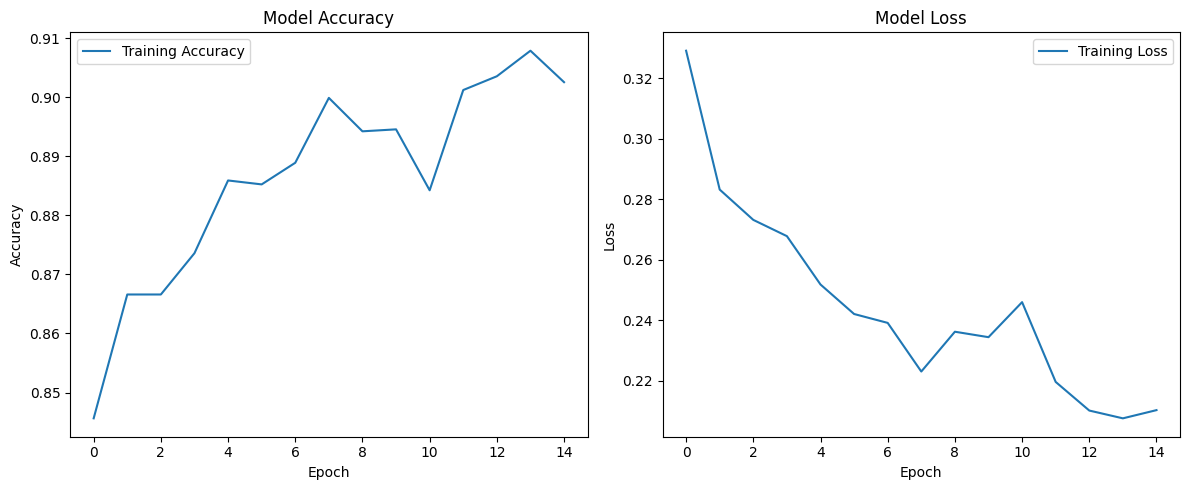

In [9]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
if 'val_accuracy' in history.history:
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [10]:
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.preprocessing import image
import numpy as np

# Load and resize the image
img_path = '/kaggle/input/images/polyp-image.jpg'  # Update this to your image path
img = image.load_img(img_path, target_size=(224, 224))

# Convert to array and add batch dimension
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

# Preprocess the input as required by DenseNet
img_data = preprocess_input(x)


In [11]:
prediction = model.predict(img_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


In [12]:
predicted_class = (prediction > 0.5).astype(int)

In [13]:
label_map = {0: "normal", 1: "polyp"}
print(f"Predicted class: {label_map[int(predicted_class[0][0])]}")

Predicted class: polyp


In [19]:
from tensorflow.keras.models import load_model

model.save('densenet_model.h5')